In [1]:
from src.porousflow.media_generator.utils.binary_blobs import periodic_binary_blobs
from src.porousflow.media_generator.utils.precolation_check import detect_percolation, fill_non_percolating_fluid, fill_non_percolating_fluid_periodic
from src.porousflow.lbm.lbm import LBM_solver
from src.porousflow.dispersion import run_dispersion_sim_physical_test
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
Num_sim = 5
imgs = np.zeros((Num_sim,128,128))
i =0 
j=0
p = np.linspace(0.1,0.7,Num_sim)
while j<Num_sim:
    media = periodic_binary_blobs(n_dim=2, length=128,volume_fraction=0.1,blob_size_fraction=0.1, seed=i)
    x_perc, y_perc, _ = detect_percolation(media)
    if x_perc and y_perc:
        imgs[j] = fill_non_percolating_fluid_periodic(media)
        filled = imgs[j]
        j+=1
        print(i,j)
        break
        
    i+=1
        

0 1


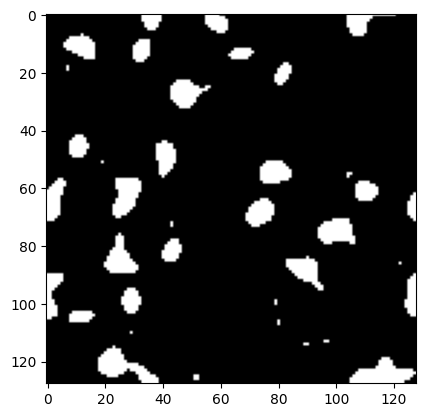

In [3]:
plt.imshow(media,cmap='gray')

In [4]:
us = np.zeros((Num_sim,128,128,2))
# for k in range(Num_sim):
us[0] = LBM_solver(imgs[0],force_dir=0,tau=0.6,force_strength=1e-1,max_iterations=50000)[0]

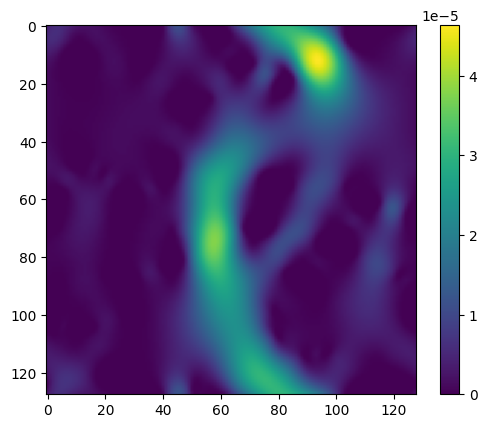

In [5]:
plt.imshow(us[0,:,:,0]**2+us[0,:,:,1]**2,cmap='viridis')
plt.colorbar()

In [12]:
target_Pe = 50
L = 128#0.25 * 128 * (0.1)
Pe_range = np.array([0,10,50,100,500])
alpha_range = Pe_range/L
# dt = 1e-3
u_mean = np.mean(us[0,~media])
u = us[0]/u_mean
v = np.max(u)*alpha_range
dt = np.zeros_like(v)

# bx=np.max(ux)
    # by=np.max(uy)
    # a = 0.5
    # dtx = ((-1+np.sqrt(1+2*a*bx))**2)/(2*bx**2)
    # dty = ((-1+np.sqrt(1+2*a*bx))**2)/(2*by**2)
a=0.2
dt[1:] = (-1+np.sqrt(1+2*a*v[1:]))**2/(2*v[1:]**2)
dt[0] = 0.5**2/2
print(dt)
steps = 50*L**2#int(1e6)
print(steps)
Ms = np.zeros((Num_sim,steps,2,2))
for n in range(Num_sim):
    # if n ==5:
    D_m = 1#L/Pe_range[n]
    _, Ms[n], _ = run_dispersion_sim_physical_test(solid=imgs[0], velocity=us[0], velocity_strength=alpha_range[n],steps=steps, num_particles=500, D=D_m,dt=dt[n])
    # _, Ms[n], _ = run_dispersion_sim_physical_test(solid=imgs[n], velocity=us[n],steps=steps, num_particles=200, dt=dt)


[0.125      0.01820882 0.01369871 0.01068744 0.00427323]
819200


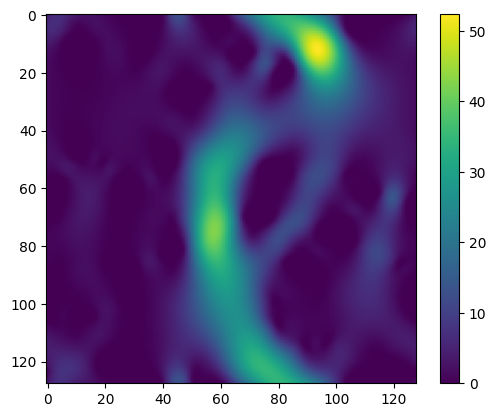

In [13]:
plt.imshow(u[:,:,0]**2+u[:,:,1]**2,cmap='viridis')
plt.colorbar()

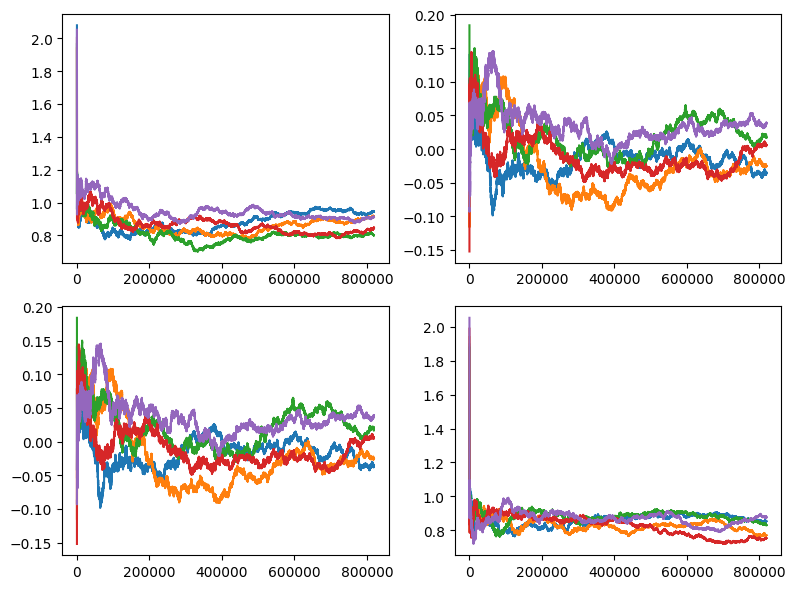

In [14]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
for m in range(Num_sim):
    # if m == 5:
    t_ = np.arange(Ms.shape[1])*dt[m]
    ax[0,0].plot(Ms[m,1:,0,0]/(2*t_[1:]))
    ax[0,1].plot(Ms[m,1:,0,1]/(2*t_[1:]))
    ax[1,0].plot(Ms[m,1:,1,0]/(2*t_[1:]))
    ax[1,1].plot(Ms[m,1:,1,1]/(2*t_[1:]))

# for i,a in enumerate(ax.flatten()):
    # a.axvline(t, color='r', linestyle='--', label=r'$t=L^2/D_m$')
    # a.axvline(tlong, color='g', linestyle='--', label=r'$10\cdot t$')
    # a.legend()
    # a.set_xscale('log')
    # a.set_yscale('log')
plt.tight_layout()
plt.show()